In [1]:
# _*_ coding: utf-8 _*_

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()  #交互模式 

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  0.4.1
Torchvision Version:  0.2.0


In [10]:
data_dir   = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception] 
model_name = "vgg"

#类型总数
num_classes = 2

batch_size = 8

num_epochs = 15

feature_extract = True


In [3]:
#The is_inception flag is used to accomodate the Inception v3 model
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,is_inception=False):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  #预测 
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train' :
                        #From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs , labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [4]:
#set model's .requires_grad attribute
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    #所有有声明的变量会被初始化。这些变量都是根据模型特例化的，专有的
    model_ft = None
    input_size = 0
    
    if model_name == "resnet":
        """
        Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.infeatures
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """
        VGG11 with batch normalization
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

In [16]:
#Load data 
#训练集上的数据增强及归一化，验证集上的归一化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]
    ),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]
    ),
}

print("Initializing Datasets and Dataloaders...")
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val'] }
dataloaders_dict = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val']
              }
dataset_sizes = { x: len(image_datasets[x]) for x in ['train', 'val'] }
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [17]:
#构建更新参数的optimizer

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn: ")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
             print("\t", name)
                
optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
                

Params to learn: 
	 classifier.6.weight
	 classifier.6.bias


In [18]:
#Run training and validation step
#Setup the loss fxn
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.6060 Acc: 0.8197
val Loss: 1.0589 Acc: 0.7712

Epoch 1/14
----------
train Loss: 0.6422 Acc: 0.8689
val Loss: 0.3564 Acc: 0.9412

Epoch 2/14
----------
train Loss: 0.7930 Acc: 0.8443
val Loss: 0.2806 Acc: 0.9412

Epoch 3/14
----------
train Loss: 0.6776 Acc: 0.8852
val Loss: 0.2250 Acc: 0.9346

Epoch 4/14
----------
train Loss: 1.2240 Acc: 0.8484
val Loss: 0.3739 Acc: 0.9477

Epoch 5/14
----------
train Loss: 0.8566 Acc: 0.8852
val Loss: 0.3910 Acc: 0.9477

Epoch 6/14
----------
train Loss: 0.9199 Acc: 0.8648
val Loss: 0.3626 Acc: 0.9412

Epoch 7/14
----------
train Loss: 0.5464 Acc: 0.8934
val Loss: 0.6587 Acc: 0.9020

Epoch 8/14
----------
train Loss: 0.7776 Acc: 0.8852
val Loss: 0.5730 Acc: 0.9020

Epoch 9/14
----------
train Loss: 0.5775 Acc: 0.9221
val Loss: 0.4091 Acc: 0.9216

Epoch 10/14
----------
train Loss: 0.5015 Acc: 0.9057
val Loss: 0.4285 Acc: 0.9150

Epoch 11/14
----------
train Loss: 0.6211 Acc: 0.9180
val Loss: 0.5249 Acc: 0.9346

Ep

Epoch 0/14
----------
train Loss: 1.1194 Acc: 0.4836
val Loss: 4.8043 Acc: 0.5425

Epoch 1/14
----------
train Loss: 4.0028 Acc: 0.5041
val Loss: 5.8613 Acc: 0.6144

Epoch 2/14
----------
train Loss: 1.5135 Acc: 0.5861
val Loss: 1.6874 Acc: 0.5686

Epoch 3/14
----------
train Loss: 1.5443 Acc: 0.6066
val Loss: 1.0940 Acc: 0.6732

Epoch 4/14
----------
train Loss: 0.9054 Acc: 0.6230
val Loss: 1.0542 Acc: 0.5621

Epoch 5/14
----------
train Loss: 1.0278 Acc: 0.6189
val Loss: 0.8089 Acc: 0.5752

Epoch 6/14
----------
train Loss: 0.9210 Acc: 0.6270
val Loss: 1.1010 Acc: 0.6078

Epoch 7/14
----------
train Loss: 0.8300 Acc: 0.5779
val Loss: 0.7643 Acc: 0.6797

Epoch 8/14
----------
train Loss: 0.8941 Acc: 0.6352
val Loss: 1.2003 Acc: 0.6536

Epoch 9/14
----------
train Loss: 0.9821 Acc: 0.5779
val Loss: 0.7789 Acc: 0.7190

Epoch 10/14
----------
train Loss: 0.7350 Acc: 0.6066
val Loss: 0.7523 Acc: 0.6928

Epoch 11/14
----------
train Loss: 0.7445 Acc: 0.6270
val Loss: 0.7216 Acc: 0.6471

Ep

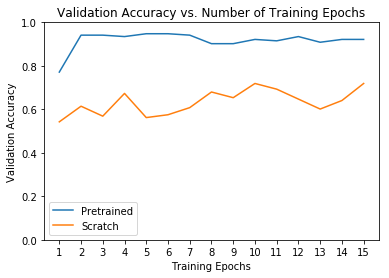

In [19]:
# Comparison with Model Trained from Scratch
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()